In [5]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

def household_guess(a_grid,r,z_grid,gamma,T):
    new_z = np.ones((z_grid.shape[0],1))
    wel = (1 + r) * a_grid[np.newaxis,:] + new_z + T[:,np.newaxis]
    V_prime = (1 + r) * (wel * 0.1) ** (-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc):

    c_prime = (beta *(1+tauc)* V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t

    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)

    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r)/(1+tauc) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it
    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset])/(1+tauc)
        V_prime[indexes_asset] = (1 + r)/(1+tauc) * (c[indexes_asset]) ** (-gamma)
        
    uce = e_grid[:,np.newaxis] * c ** (-gamma)

    return V_prime,a,c,uce

def income(e_grid, w, N, taun):
    z_grid = (1 - taun) * w * N * e_grid
    return z_grid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  (Transfer) / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

hh_inp = household.add_hetinputs([make_grid,transfers,income])

@simple
def firm(Y, w, Z, pi, mu, kappa):
    N = Y / Z
    Div = Y - w * N - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return Div, N

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, Transfer, B, C, N, tauc, taun, w):
    govt_res = Transfer + (1 + r) * B(-1) - tauc * C - taun * w * N - B
    return govt_res

@simple
def mkt_clearing(A, C, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple 
def union_ss(w, N, UCE, kw, v, muw, tauc, taun):
    phi = ((1 - taun) * w * N ** (-v) * UCE) / ((1 + tauc) * muw) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw))
    return wnkpc, phi

blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

calibration = {'gamma': 1.0, 'v': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5, 'B': 6.0,
               'kw': 0.0025, 'muw': 1.2, 'N': 1.0, 'tauc': 0.1, 'taun': 0.0}

unknowns_ss = {'beta': 0.986, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, backward_tol = 1E-22, solver="hybr")

In [6]:
print("Asset Mkt ", ss0['asset_mkt'])
print("Goods Mkt (Untargeted) ", ss0['goods_mkt'])

Asset Mkt  4.085620730620576e-14
Goods Mkt (Untargeted)  -7.466973039882419e-09


In [7]:
ss0

<SteadyStateDict: ['gamma', 'v', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B', 'kw', 'muw', 'N', 'tauc', 'taun', 'beta', 'Transfer', 'w', 'Div', 'r', 'A', 'C', 'UCE', 'wnkpc', 'phi', 'govt_res', 'asset_mkt', 'goods_mkt'], internals=['household']>

In [8]:
@simple
def wage(pi, w):
    piw = (1 + pi) * w / w(-1) - 1
    return piw

@simple
def union(piw,w,N,UCE,kw,phi,v,muw,beta,tauc,taun):
    wnkpc = (kw * (phi * N ** (1+v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw)) 
             + beta * (1 + piw(+1)).apply(np.log) - (1 + piw).apply(np.log))
    return wnkpc

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc,wage,union]
hank = create_model(blocks, name = "One-Asset HANK")

ss = hank.steady_state(ss0)

T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y', 'Transfer']
targets = ['nkpc_res', 'asset_mkt', 'wnkpc', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

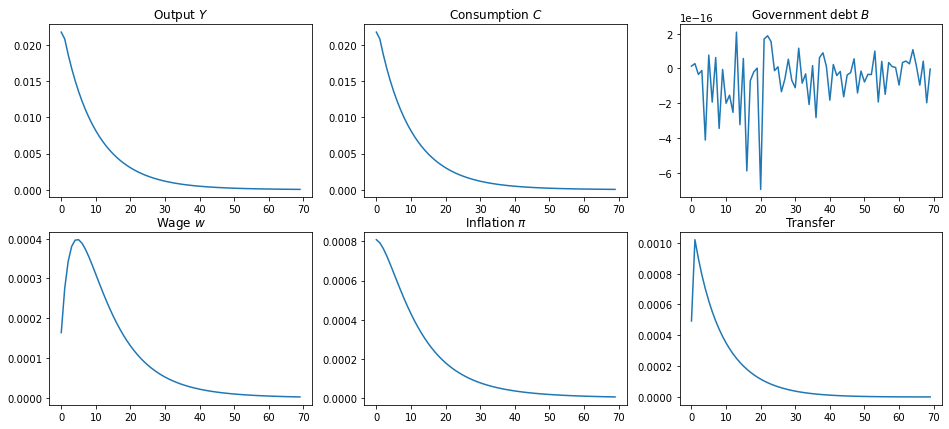

In [9]:
rhos = 0.9
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])

dY = G['Y']['rstar'] @ drstar
dC = G['C']['rstar'] @ drstar
dN = G['N']['rstar'] @ drstar
dB = G['A']['rstar'] @ drstar
dw = G['w']['rstar'] @ drstar
dp = G['pi']['rstar'] @ drstar
dr = G['r']['rstar'] @ drstar
dD = G['Transfer']['rstar'] @ drstar
dd = G['Div']['rstar'] @ drstar,

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 3)

ax[0, 0].set_title(r'Output $Y$')
#l1, = ax[0, 0].plot(dY[0][:50, :])
l1, = ax[0, 0].plot(dY[:70, :] * ss0['Y'])

ax[0, 1].set_title(r'Consumption $C$')
#ax[0, 1].plot(dC[0][:50, :])
ax[0, 1].plot(dC[:70, :] * ss0['C'])

ax[0, 2].set_title(r'Government debt $B$')
#ax[0, 2].plot(dB[0][:50, :])
ax[0, 2].plot(dB[:70, :] * ss0['A'])

ax[1, 0].set_title(r'Wage $w$')
#ax[1, 0].plot(dw[0][:50, :])
ax[1, 0].plot(dw[:70, :] * ss0['w'])

ax[1, 1].set_title(r'Inflation $\pi$')
#ax[1, 1].plot(dp[0][:50, :])
ax[1, 1].plot(dp[:70, :])

#ax[1, 2].set_title(r'Real interest rate $r$')
#ax[1, 2].plot(dr[0][:50, :])
#ax[1, 2].plot(dr[1][:50, :])
#ax[1, 2].plot(dr[2][:50, :],'-.')

ax[1, 2].set_title(r'Transfer')
#ax[1, 2].plot(dD[0][:50, :])
ax[1, 2].plot(dD[:70, :] * ss0['Transfer'])

plt.show()